In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import hashlib
from itertools import count
import random
from os.path import join
from collections import Counter
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric import nn as tnn
from torch_scatter import scatter_mean
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.data import Batch

In [2]:
vocab_sizes = [500, 50000]
underscore = "▁"
fairseq_dir = "/nfs/team/nlp/users/rgupta/NMT/code/fairseq/"
langs = ['en', 'de']
NUM_IN_FEATURES = 100
NUM_OUT_FEATURES = 100
NUM_SENTS = 10 ** 5
NUM_NEGATIVE = 1
BATCH_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
with open("../data/local/semantic_similarity.pickle", "rb") as f:
    dataset = pickle.load(f)
dataset = dataset[:NUM_SENTS]

In [4]:
dicts = {}
for v in vocab_sizes:
    with open(join(fairseq_dir, f"data/local/train_files/iwslt14-en-de-{v}-no-max-filter-dict.en")) as f:
        dicts[v] = dict([line.strip().split() for line in f])

In [5]:
shared_vocab = {'OOV': 0}
for v in vocab_sizes:
    for token in dicts[v].keys():
        k = f"{v}|{token}"
        shared_vocab[k] = len(shared_vocab)

In [6]:
sents = {}
words = {}
for lang in langs:
    sents[lang] = {}
    for v in vocab_sizes:
        with open(join(fairseq_dir, f"data/local/train_files/iwslt14-en-de-{v}-no-max-filter-train.{lang}")) as f:
            sents[lang][v] = [line.strip().split() for line in f]
    words[lang] = [''.join(pieces).replace(underscore, ' ')[1:].split() for pieces in sents[lang][500]]

In [7]:
corpus_size = len(words[lang])

In [8]:
word_counters = {lang: Counter([word for sent in words[lang] for word in sent]) for lang in langs}
word_counts = {lang: [count for word, count in counter.most_common()] for lang, counter in word_counters.items()}

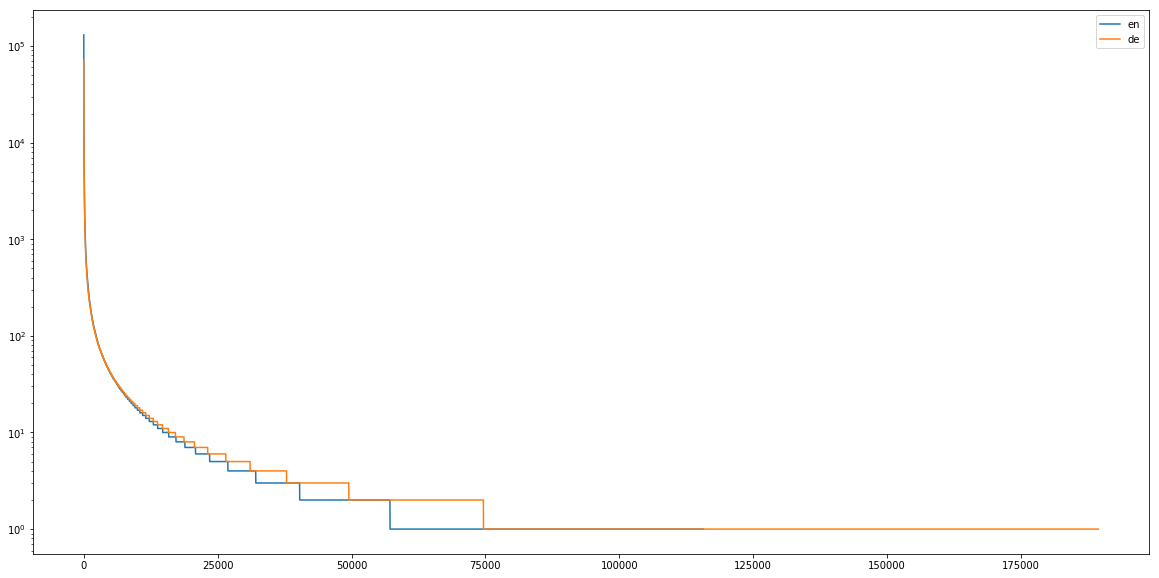

In [9]:
plt.figure(figsize=(20, 10))
for lang, counts in word_counts.items():
    plt.plot(counts, label=lang)
    plt.yscale('log')
plt.legend()
plt.show()

In [10]:
np.percentile(word_counts['en'], 80)

6.0

In [11]:
np.percentile(word_counts['de'], 80)

3.0

In [12]:
0.2 * len(word_counts['en'])

23142.600000000002

In [13]:
len(shared_vocab)

46545

In [14]:
for lang, counter in word_counters.items():
    for word, _ in counter.most_common(25000):
        key = f"word|{word}"
        shared_vocab[key] = len(shared_vocab)

In [15]:
len(shared_vocab)

94438

In [16]:
tokens = {}
for lang in langs:
    tokens[lang] = {}
    for v in vocab_sizes:
        tokens[lang][v] = []
        sent_tokens = []
        for sent in sents[lang][v]:
            buff = [sent[0]]
            for word in sent[1:]:
                if word.startswith(underscore):
                    sent_tokens.append(buff)
                    buff = [word]
                else:
                    buff.append(word)
            sent_tokens.append(buff) # last buffer
            tokens[lang][v].append(sent_tokens)
            sent_tokens = []

In [17]:
for lang in langs:
    for v in vocab_sizes:
        for i in range(corpus_size):
            assert len(words[lang][i]) == len(tokens[lang][v][i]), (lang, v, i, len(words[lang][i]), len(tokens[lang][v][i]))

In [18]:
class OOVDictionary:
    def __init__(self, d):
        self.d = d
        
    def __getitem__(self, x):
        if x in self.d:
            return self.d[x]
        else:
            return self.d['OOV']
        
    def get(self, x, default=None):
        if default is None or x in self.d:
            return self[x]
        else:
            return default
        
    def __len__(self):
        return len(self.d)

In [19]:
vocab_dict = OOVDictionary(shared_vocab)

In [20]:
sent_i = 42
row_format ="{:<25}" * (len(vocab_sizes) + 1)
print(row_format.format('word', *vocab_sizes)+ '\n')

# Print token strings
for lang in langs:
    word_list = words[lang][sent_i]
    vocab2sent_list = {vocab: tokens[lang][vocab][sent_i] for vocab in vocab_sizes}
    
    for i, word in enumerate(word_list):
        s = [word]
        s += [','.join([str(token) for token in sent_list[i]]) for sent_list in vocab2sent_list.values()]
        print(row_format.format(*s))
    print()
    
# Print token ids
for lang in langs:
    word_list = words[lang][sent_i]
    vocab2sent_list = {vocab: tokens[lang][vocab][sent_i] for vocab in vocab_sizes}
    
    for i, word in enumerate(word_list):
        s = [vocab_dict[f"word|{word}"]]
        s += [','.join([str(shared_vocab[f"{vocab}|{token}"]) for token in sent_list[i]]) for vocab, sent_list in vocab2sent_list.items()]
        print(row_format.format(*s))
    print()

word                     500                      50000                    

PCBs                     ▁P,C,B,s                 ▁PCBs                    
accumulate               ▁a,c,c,um,ul,ate         ▁accumulate              
in                       ▁in                      ▁in                      
dolphins                 ▁d,ol,p,h,in,s           ▁dolphins                
in                       ▁in                      ▁in                      
Sarasota                 ▁S,ar,as,ot,a            ▁Sar,as,ota              
Bay,                     ▁B,ay,,                  ▁Bay,,                   
in                       ▁in                      ▁in                      
Texas,                   ▁T,e,x,as,,              ▁Texas,,                 
in                       ▁in                      ▁in                      
North                    ▁N,ort,h                 ▁North                   
Carolina.                ▁C,ar,ol,in,a,.          ▁Carolina,.              

PCBs      

In [21]:
class Node:
    def __init__(self, name):
        self.name = name
        self.id = vocab_dict[name]
        
    def __repr__(self):
        return self.name

In [22]:
def plot_graph(g):
    plt.figure(figsize=(20, 20))
    groups = set(nx.get_node_attributes(g,'is_word').values())
    mapping = dict(zip(sorted(groups),count()))
    nodes = g.nodes()
    colors = [mapping[g.node[n]['is_word']] for n in nodes]

    pos = nx.kamada_kawai_layout(g)
    ec = nx.draw_networkx_edges(g, pos, alpha=0.5)
    nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, 
                                with_labels=True, node_size=200, cmap=plt.cm.Pastel1,
                                font_weight='bold')
    labels= nx.draw_networkx_labels(g,pos)
    plt.show()

In [23]:
def create_graph(words, other_toks):
    """
    words: List of words in sent.
    other_toks: Dictionary with key = vocab size and value = list of sentences tokenized with that vocab size.
    """
    g = nx.Graph()
    word_nodes = [Node(f'word|{word}') for word in words]
    bpe_nodes = [[[Node(f'{vocab}|{tok}') for tok in word] for word in sent] for vocab, sent in other_toks.items()]
    
    for i, word_node in enumerate(word_nodes):
        g.add_node(word_node, label=word_node.name, is_word=True)
        if i > 0:
            g.add_edge(word_nodes[i-1], word_nodes[i])
        
    for i, nodes in enumerate(bpe_nodes):
        for j, word in enumerate(nodes):
            for k, bpe_node in enumerate(word):
                g.add_node(bpe_node, label=bpe_node.name, is_word=False)
                g.add_edge(bpe_node, word_nodes[j])
                if k > 0:
                    g.add_edge(bpe_nodes[i][j][k], bpe_nodes[i][j][k - 1])
        
    return g

/home/rgupta/anaconda3/envs/gnn/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


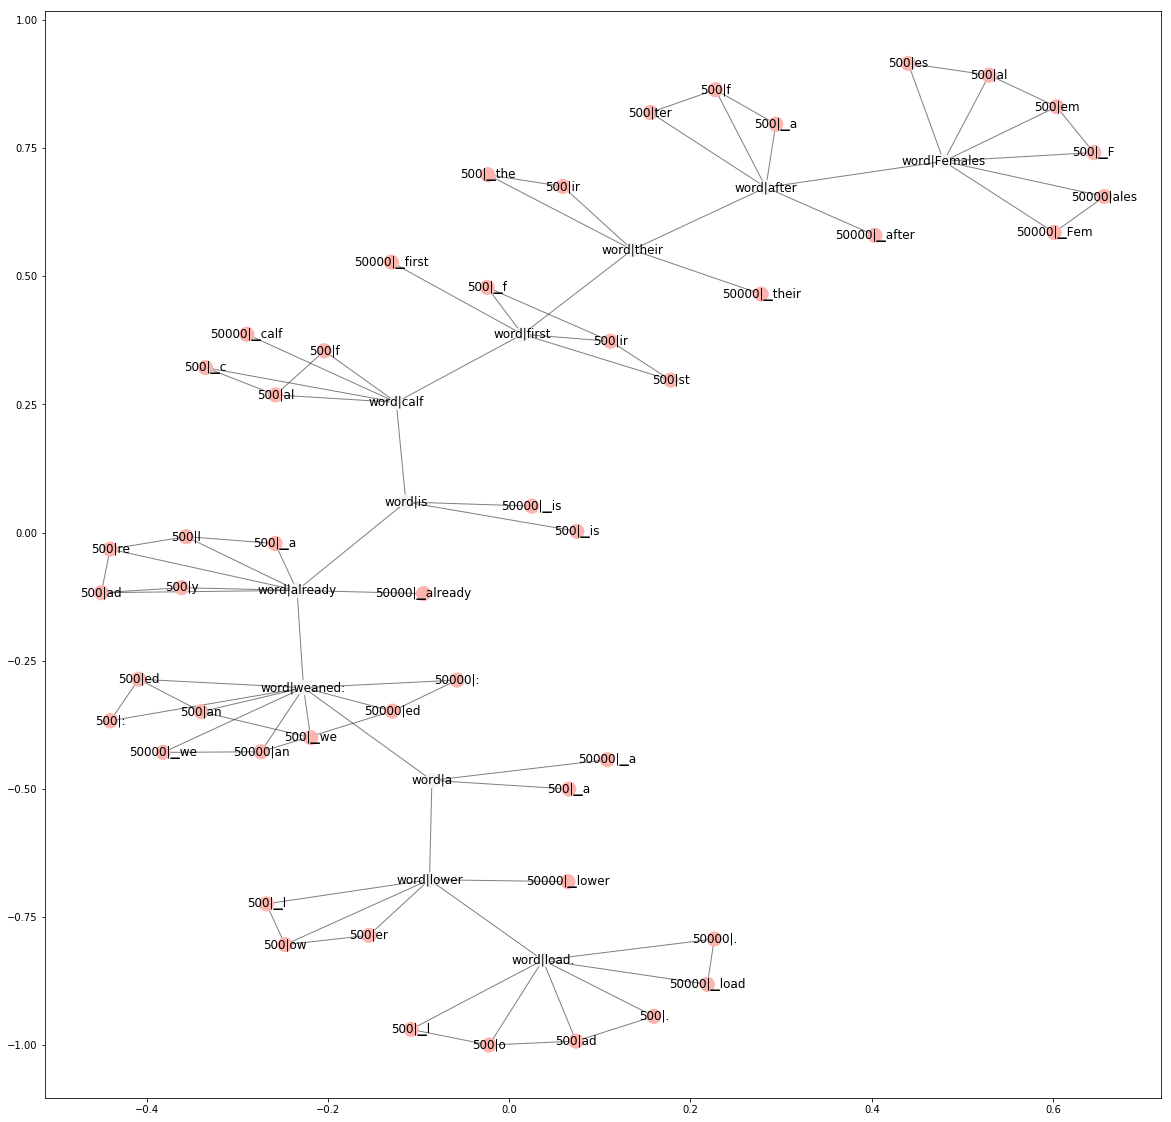

In [24]:
sent_i = 50
lang = 'en'
g = create_graph(words[lang][sent_i], {vocab:tokens[lang][vocab][sent_i] for vocab in vocab_sizes})
plot_graph(g)

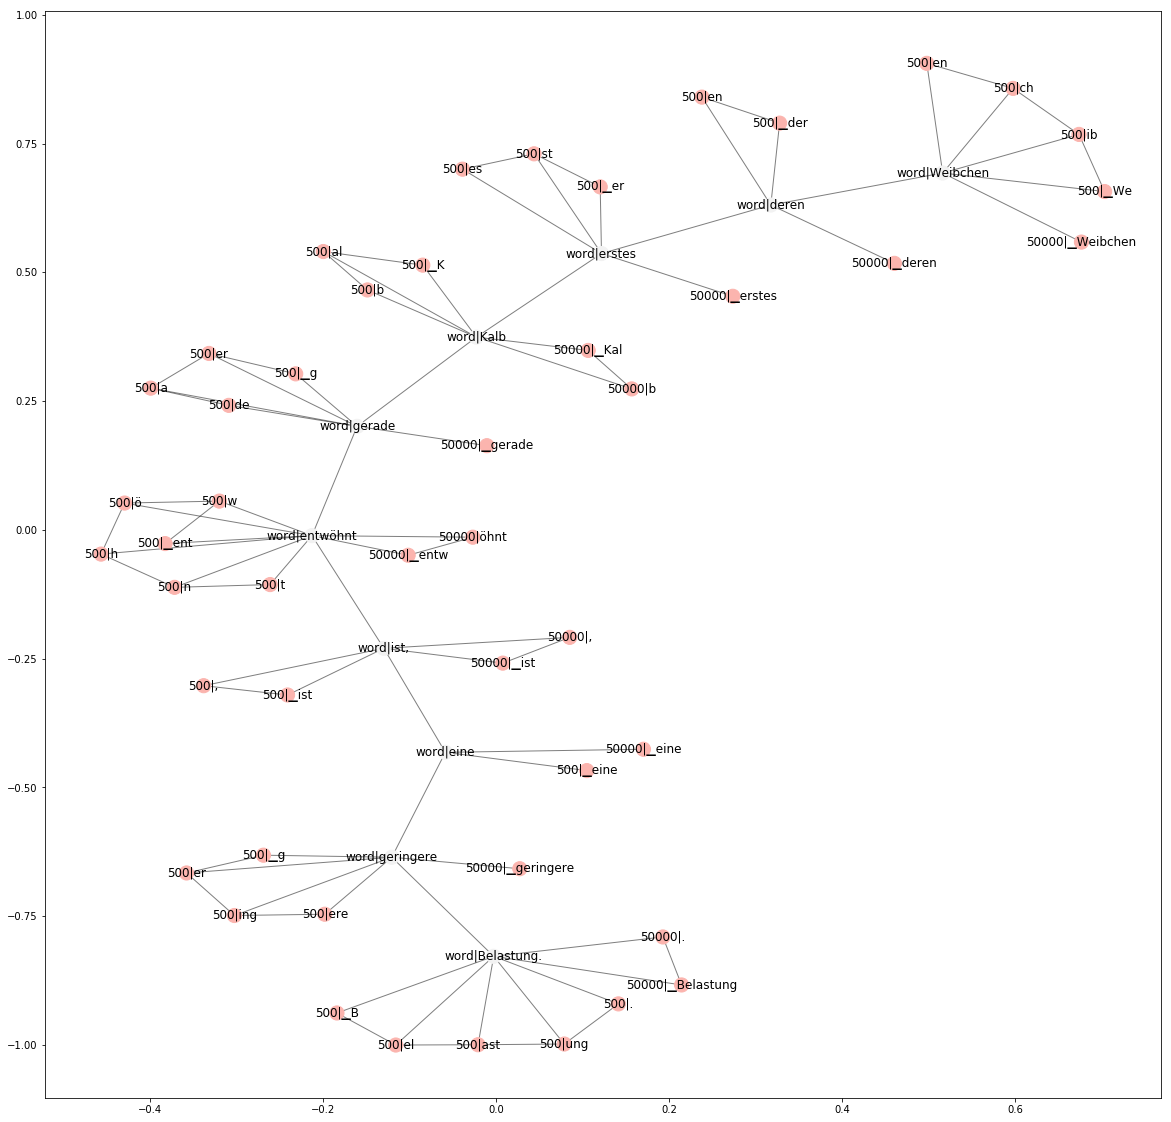

In [25]:
sent_i = 50
lang = 'de'
g = create_graph(words[lang][sent_i], {vocab:tokens[lang][vocab][sent_i] for vocab in vocab_sizes})
plot_graph(g)

In [26]:
graphs_str = {}
for lang in langs:
    graphs_str[lang] = [create_graph(words[lang][i], {vocab:tokens[lang][vocab][i] for vocab in vocab_sizes}) 
                        for i in range(corpus_size)]

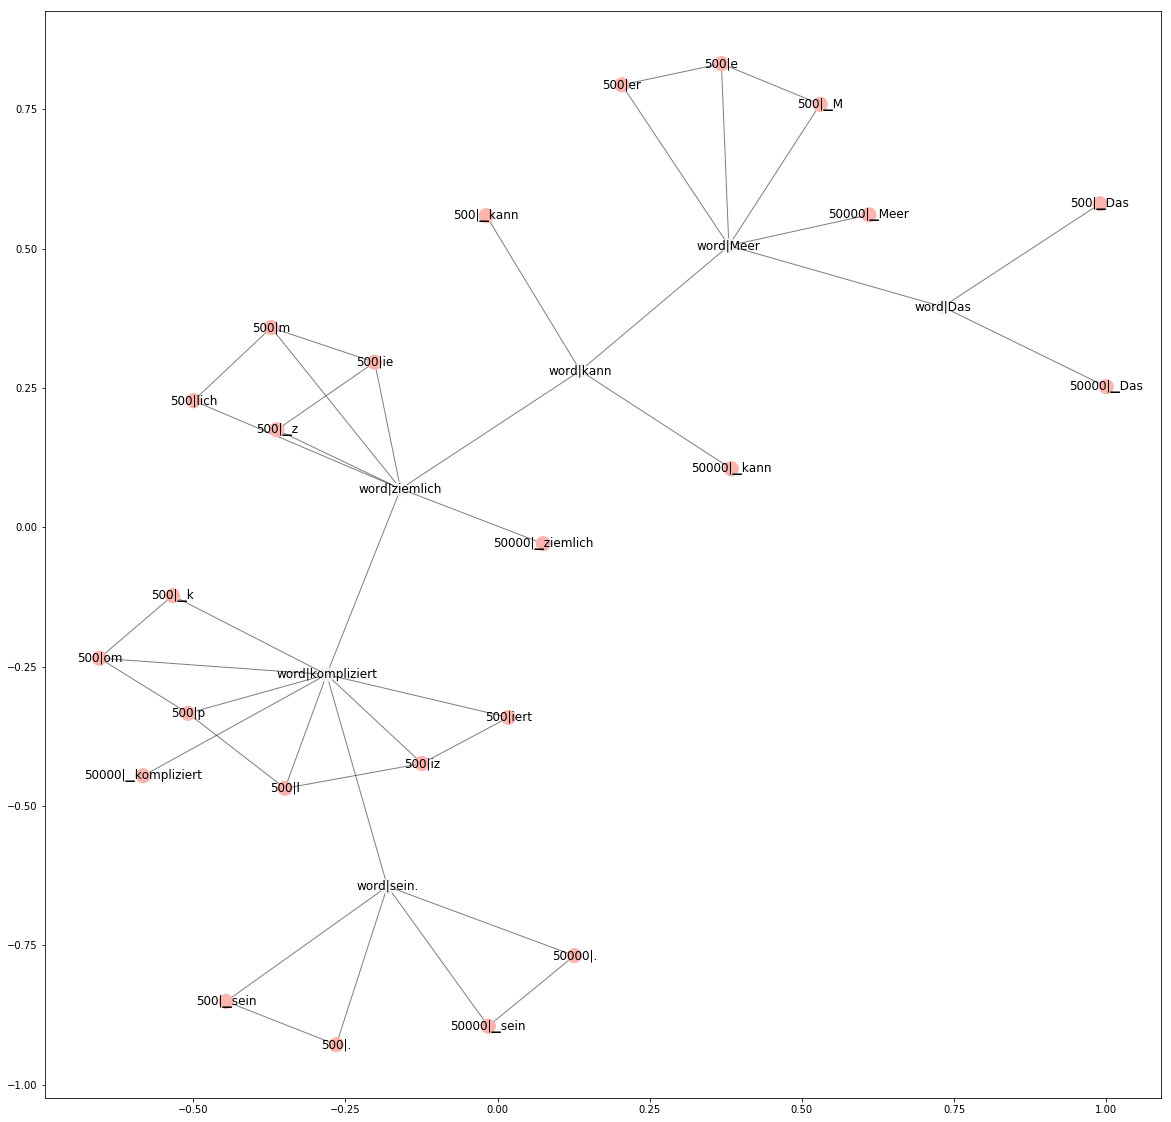

In [27]:
plot_graph(graphs_str['de'][0])

In [28]:
def relabel_graph(G):
    H = G.__class__()
    H.add_nodes_from(n.id for n in G)
    H._node.update((n.id, d.copy()) for n, d in G.nodes.items())
    H.add_edges_from((n1.id, n2.id, d.copy()) for (n1, n2, d) in G.edges(data=True))
    H.graph.update(G.graph)
    return H

In [29]:
graph_ids = {lang: [torch.tensor([node.id for node in g]) for g in graphs] 
                                                          for lang, graphs in graphs_str.items()}

In [30]:

graphs_int = {lang: [nx.convert_node_labels_to_integers(g) for g in graphs] for lang, graphs in graphs_str.items()}
graph_edges = {lang: [[e for e in g.edges] for g in graphs] for lang, graphs in graphs_int.items()}

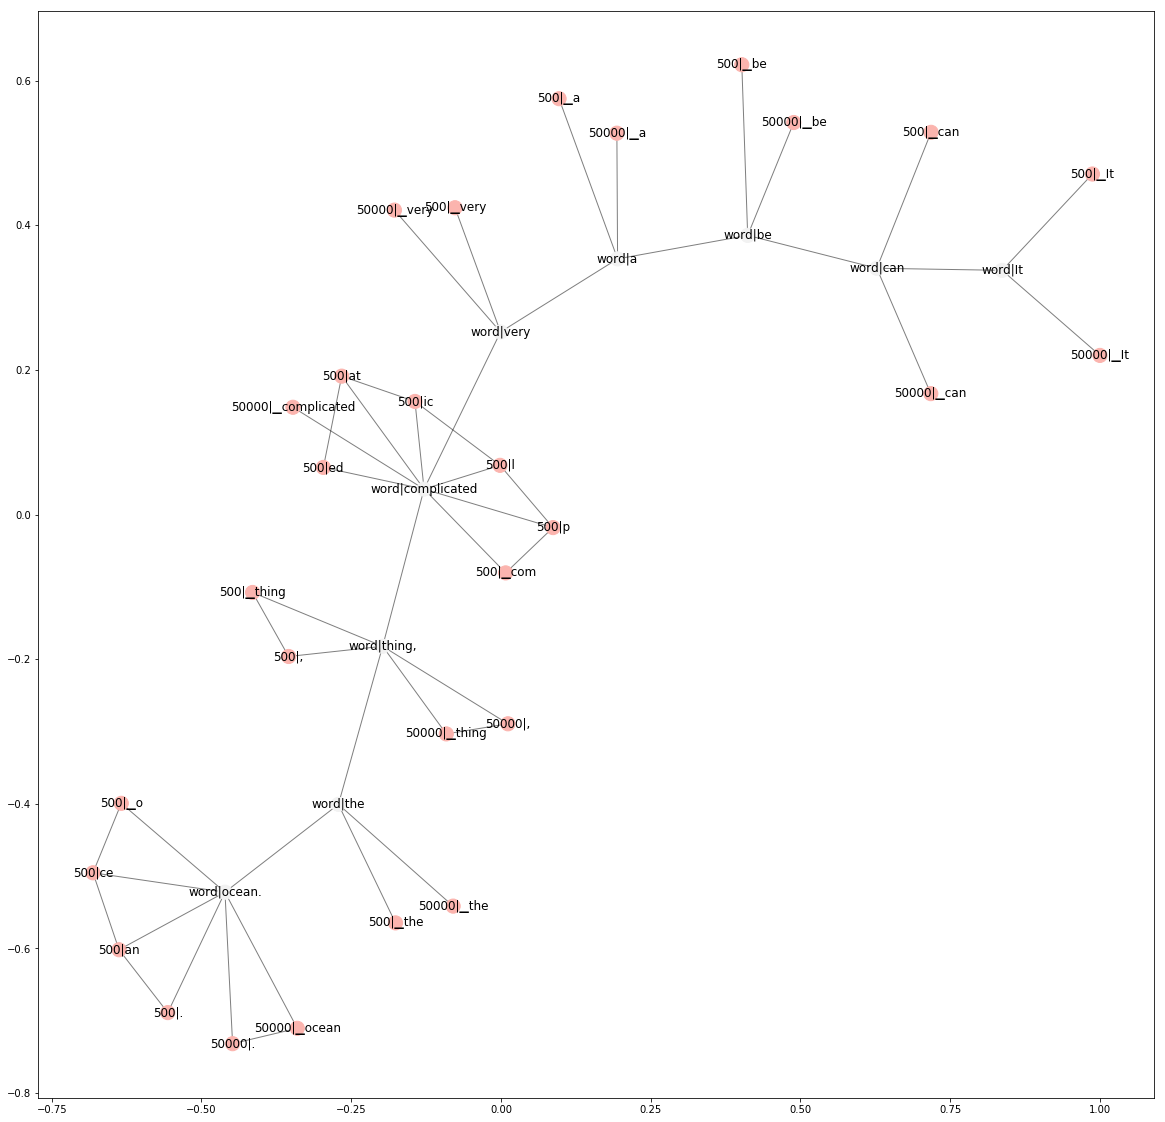

In [31]:
plot_graph(graphs_str['en'][0])

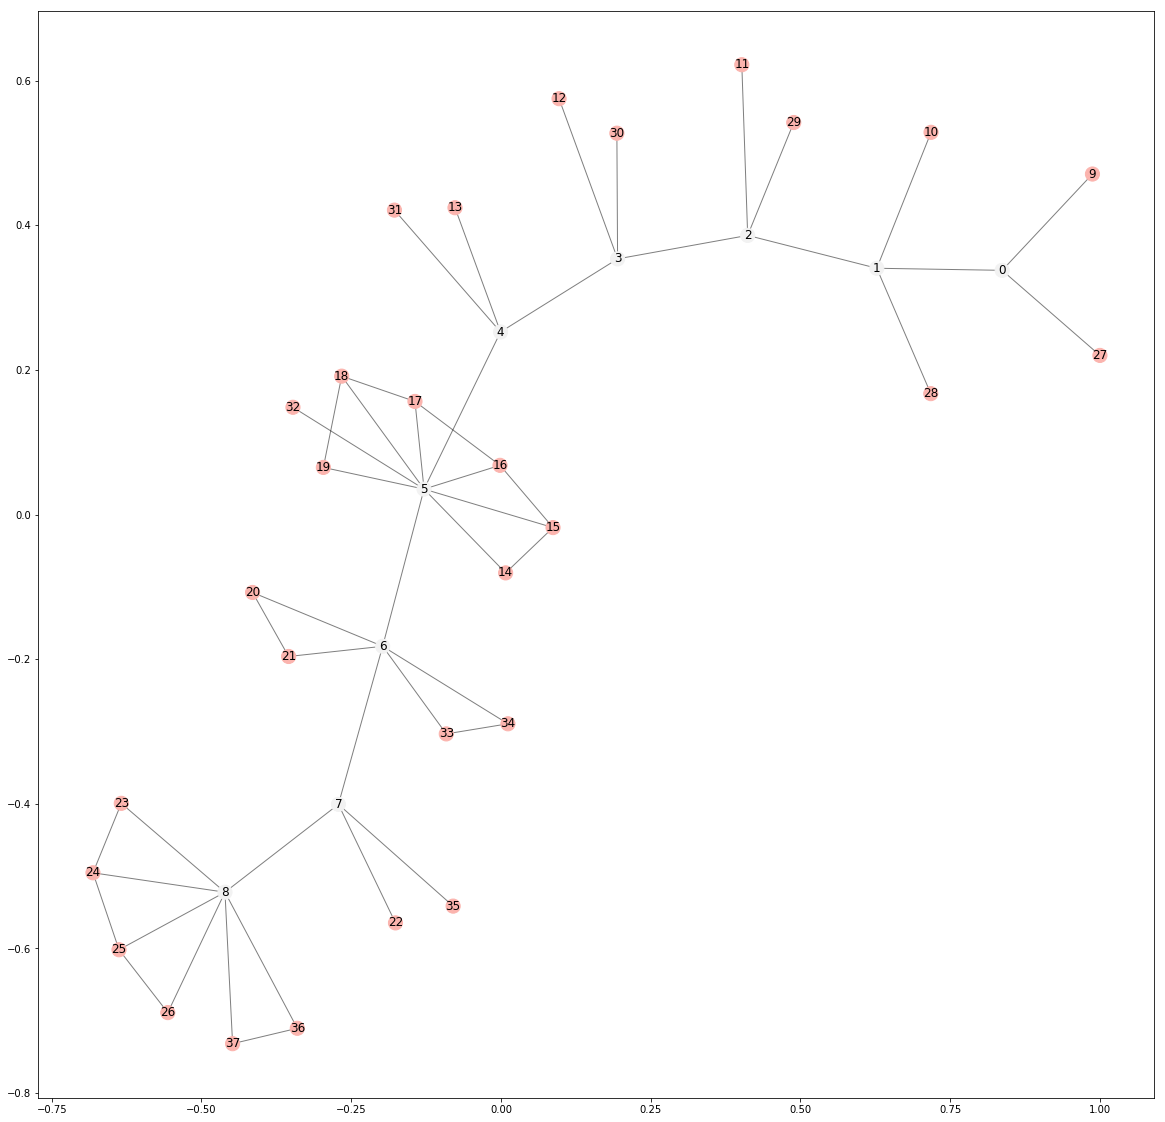

In [32]:
plot_graph(graphs_int['en'][0])

In [33]:
edge_indices = {lang:[torch.tensor(e, dtype=torch.long).t().contiguous() for e in edges] 
                for lang, edges in graph_edges.items()}
xs = {lang:[torch.zeros(1) for g in graphs] for lang, graphs in graphs_int.items()}
#ys = [torch.tensor([1 if node[1]['is_word'] else 0 for node in g.nodes(data=True)]) for g in graphs_int]

In [34]:
def rand_exclude(low, high, size, exclude):
    ans = []
    while len(ans) != size:
        r = random.randint(low, high)
        if r in exclude:
            continue
        else:
            ans.append(r)

    return ans

In [35]:
# True matches
dataset = [{'x_ids_en': graph_ids['en'][i].to(device),
            'x_ids_de': graph_ids['de'][i].to(device),
            'edge_index_en': edge_indices['en'][i].to(device),
            'edge_index_de': edge_indices['de'][i].to(device),
            'y': 1} for i in range(NUM_SENTS)] 

# Negative sampling
dataset = dataset + [{'x_ids_en': graph_ids['en'][i].to(device),
             'x_ids_de': graph_ids['de'][j].to(device),
             'edge_index_en': edge_indices['en'][i].to(device),
             'edge_index_de': edge_indices['de'][j].to(device),
             'y': 0}for i in range(NUM_SENTS) for j in rand_exclude(0, NUM_SENTS - 1, NUM_NEGATIVE, [i])] 

## BiLSTM Baseline

In [63]:
class BILSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_embedding, num_layers=2, dropout=0.3, init_state='zero'):
        super(BILSTM, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, 
                              num_layers=num_layers,
                              dropout=dropout,
                              batch_first=True,
                             bidirectional=True)
        self.init_state = init_state
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(num_embedding, input_size)
        
    def forward(self, x):
        b, l = x.shape
        x = self.emb(x)
        if self.init_state == "zero":
            h0 = torch.zeros(2 * self.num_layers, b, self.hidden_size)
            c0 = torch.zeros(2 * self.num_layers, b, self.hidden_size)
        output, (hn, cn) = self.bilstm(x, (h0, c0))
        
        return output

In [64]:
bilstm = BILSTM(100, 256, 10)

In [65]:
x = torch.randint(0, 10, size=(5, 10))
y = bilstm(x)

In [66]:
y.shape

torch.Size([5, 10, 512])

## Save Dataset

In [37]:
words['dea
      '][0]

['Das', 'Meer', 'kann', 'ziemlich', 'kompliziert', 'sein.']

In [ ]:
with open("../data/local/semantic_similarity.pickle", "wb") as f:
    pickle.dump(dataset, f)

In [ ]:
len(dataset)

## Train-Valid Split

In [ ]:
np.random.seed = 42
permute = np.random.permutation(len(dataset)).tolist()

train = []
dev = []
train_size = int(0.8 * len(permute))
dev_size = len(dataset) - train_size

for i in permute:
    if len(train) < train_size:
        train.append(dataset[i])
    else:
        dev.append(dataset[i])

## GNN

### Model

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, aggr='sum', num_hidden=256, emb_size=128, out_size=128):
        super(Net, self).__init__()
        self.embed = nn.Embedding(len(vocab_dict), emb_size)
        self.conv1 = GCNConv(emb_size, num_hidden)
        self.conv2 = GCNConv(num_hidden, out_size)
        self.aggr = aggr

    def forward(self, data):
        edge_index, x_ids = data.edge_index, data.node_ids
        x = self.embed(x_ids)

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        
        if self.aggr == 'sum':
            x = scatter_mean(x, data.batch, dim=0)

        return x

In [ ]:
def batchify(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [ ]:
def validate(model, batch_size=32):
    model.eval()
    accs = []
    for i, batch in enumerate(batchify(dev, batch_size)):
        batch_en = Batch.from_data_list([Data.from_dict({'edge_index': g['edge_index_en'],
                                                         'node_ids': g['x_ids_en']}) for g in batch]).to(device)
        batch_de = Batch.from_data_list([Data.from_dict({'edge_index': g['edge_index_de'],
                                                         'node_ids': g['x_ids_de']}) for g in batch]).to(device)
        y = torch.tensor([g['y'] for g in batch]).to(device)
        
        out_en = model(batch_en)
        out_de = model(batch_de)
        # print(f"Out Model, out_en shape: {out_en.shape}, out_de shape: {out_de.shape}")
        
        preds = (out_en * out_de).sum(dim=1) > 0
        # print(f"Validate, preds: {preds}, y: {y}")
        accs.append(torch.eq(preds, y.byte()).sum().item())
        
    return np.average(accs)

In [ ]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
BATCH_SIZE = 256

In [ ]:
for epoch in range(5):

    model.train()
    for i, batch in enumerate(batchify(train, BATCH_SIZE)):
        
        batch_en = Batch.from_data_list([Data.from_dict({'edge_index': g['edge_index_en'],
                                                         'node_ids': g['x_ids_en']}) for g in batch]).to(device)
        batch_de = Batch.from_data_list([Data.from_dict({'edge_index': g['edge_index_de'],
                                                         'node_ids': g['x_ids_de']}) for g in batch]).to(device)
        y = torch.tensor([g['y'] for g in batch], dtype=torch.float).to(device)
        
        optimizer.zero_grad()
        out_en = model(batch_en)
        out_de = model(batch_de)
        scores = F.sigmoid((out_en * out_de).sum(dim=1)) # dot product
        
        if i % 100 == 0:
            print(f"i: {i}, Mean: {torch.mean(scores)}, STD: {torch.std(scores)}")
        
        loss = F.binary_cross_entropy(scores, y.float())
        loss.backward()
        optimizer.step()
    acc = validate(model, batch_size=BATCH_SIZE)
    print(f"Epoch: {epoch}, Accuracy: {acc}")